In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('C:/Users/pc/Documents/GitHub/Healthcare-test-results-classification-using-Machine-Learning/Preprocessed Datasets/Training_Set_Preprocessed_Final.csv')

In [4]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [5]:
print(f"Original dataframe size: {len(df)}")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")

Original dataframe size: 44167
Training set size: 30916
Validation set size: 6625
Testing set size: 6626


In [6]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

In [7]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
X_train = df_train.drop('Test Results', axis=1)
y_train = df_train['Test Results']
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [23:12:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [8]:
# Print best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy for XGBoost:", grid_search_xgb.best_score_)

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
Best cross-validation accuracy for XGBoost: 0.8550911672220642


In [9]:
# Make predictions on test set
X_test = df_test.drop('Test Results', axis=1)
y_test = df_test['Test Results']
y_pred_xgb = grid_search_xgb.predict(X_test)

In [10]:
# Get classification report
report = classification_report(y_test, y_pred_xgb, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']  # Sensitivity
f1 = report['weighted avg']['f1-score']
accuracy = accuracy_score(y_test, y_pred_xgb)

Performance Metrics for XGBoost on Test Set:
        Metric     Value
0    Precision  0.865789
1  Sensitivity  0.865982
2     F1 Score  0.865864
3     Accuracy  0.865982


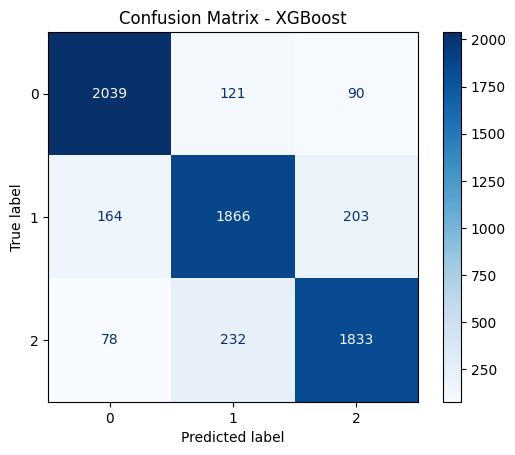

In [11]:
# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Sensitivity', 'F1 Score', 'Accuracy'],
    'Value': [precision, recall, f1, accuracy]
})

print("Performance Metrics for XGBoost on Test Set:")
print(metrics_df)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.show()